<a href="https://colab.research.google.com/github/LovingChester/mlportfolio/blob/main/Airline_delay_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Airline delay prediction 
This notebook will build models to predict the delay of flights. The dataset comes from https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

#### Import needed libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import scipy.stats as st

#### Read data and EDA

In [2]:
airline_df = pd.read_csv('drive/MyDrive/ML_dataset/Airlines.csv')
airline_df.head(10)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
5,6,CO,1094,LAX,IAH,3,30,181,1
6,7,DL,1768,LAX,MSP,3,30,220,0
7,8,DL,2722,PHX,DTW,3,30,228,0
8,9,DL,2606,SFO,MSP,3,35,216,1
9,10,AA,2538,LAS,ORD,3,40,200,1


In [3]:
airline_df.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.000000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.604461,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.000000,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [4]:
airline_df.isnull().sum()

id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

Drop not needed columns

In [5]:
airline_df = airline_df.drop(['id'], axis=1)
airline_df.head(10)

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,269,SFO,IAH,3,15,205,1
1,US,1558,PHX,CLT,3,15,222,1
2,AA,2400,LAX,DFW,3,20,165,1
3,AA,2466,SFO,DFW,3,20,195,1
4,AS,108,ANC,SEA,3,30,202,0
5,CO,1094,LAX,IAH,3,30,181,1
6,DL,1768,LAX,MSP,3,30,220,0
7,DL,2722,PHX,DTW,3,30,228,0
8,DL,2606,SFO,MSP,3,35,216,1
9,AA,2538,LAS,ORD,3,40,200,1


#### Data Visualization

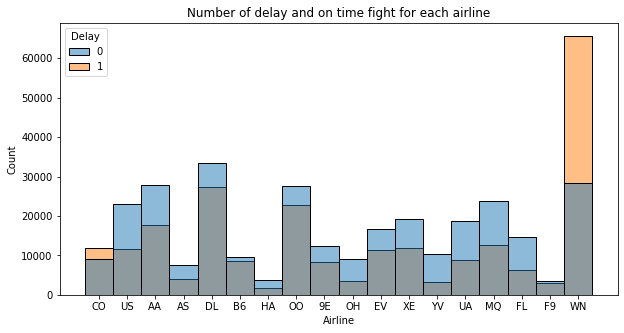

In [6]:
plt.figure(figsize=(10, 5))
plt.title('Number of delay and on time fight for each airline')
sns.histplot(x='Airline', hue='Delay', data=airline_df)
plt.show()

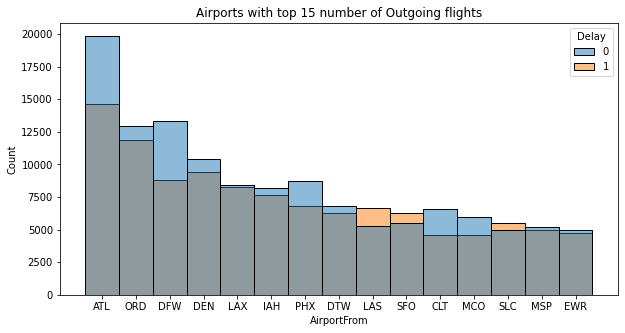

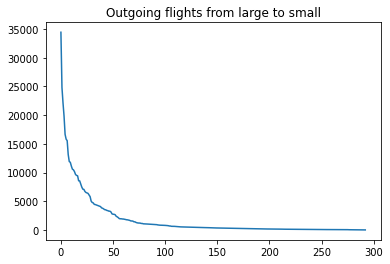

In [7]:
plt.figure(figsize=(10, 5))
from_df = pd.DataFrame(airline_df['AirportFrom'].value_counts()).head(15).reset_index()
from_df.rename(columns={"index": "AirportFrom", "AirportFrom": "FromCount"}, inplace=True)
airline_from = from_df.merge(airline_df)
plt.title('Airports with top 15 number of Outgoing flights')
sns.histplot(x='AirportFrom', hue='Delay', data=airline_from)
plt.show()

plt.title('Outgoing flights from large to small')
plt.plot(airline_df['AirportFrom'].value_counts().values)
plt.show()

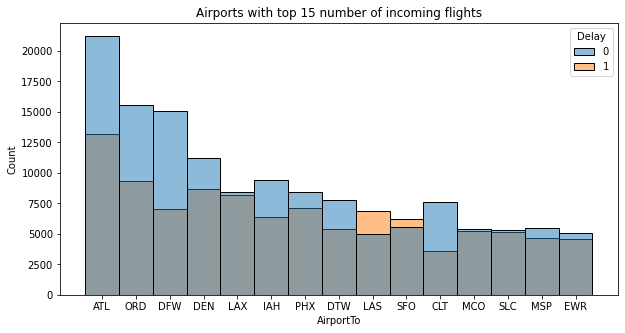

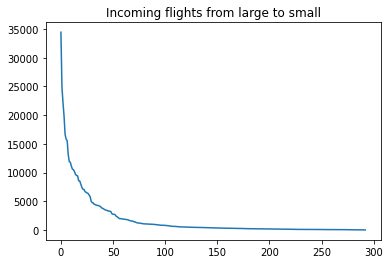

In [8]:
plt.figure(figsize=(10, 5))
to_df = pd.DataFrame(airline_df['AirportTo'].value_counts()).head(15).reset_index()
to_df.rename(columns={"index": "AirportTo", "AirportTo": "ToCount"}, inplace=True)
airline_to = to_df.merge(airline_df)
plt.title('Airports with top 15 number of incoming flights')
sns.histplot(x='AirportTo', hue='Delay', data=airline_to)
plt.show()

plt.title('Incoming flights from large to small')
plt.plot(airline_df['AirportTo'].value_counts().values)
plt.show()

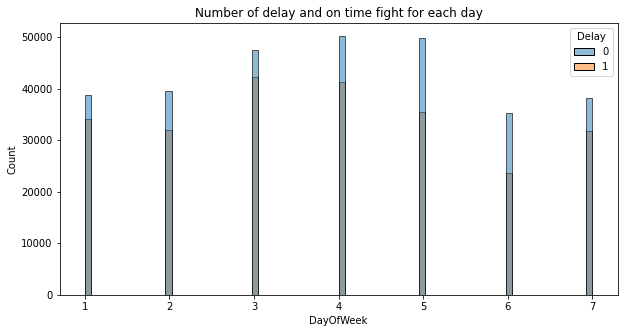

In [9]:
plt.figure(figsize=(10, 5))
plt.title('Number of delay and on time fight for each day')
sns.histplot(x='DayOfWeek', hue='Delay', data=airline_df)
plt.show()

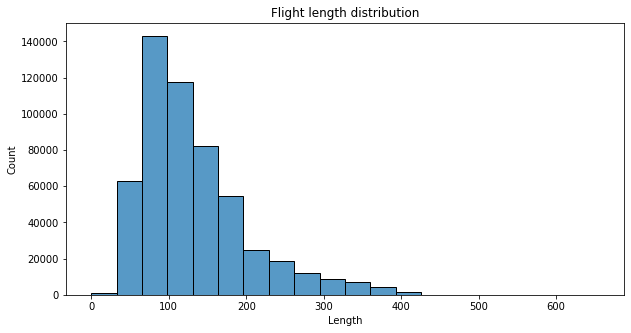

In [10]:
plt.figure(figsize=(10, 5))
plt.title('Flight length distribution')
sns.histplot(x='Length', data=airline_df, bins=20)
plt.show()

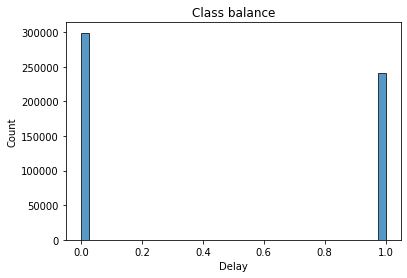

In [11]:
plt.title('Class balance')
sns.histplot(x='Delay', data=airline_df)
plt.show()

Correlation heatmap

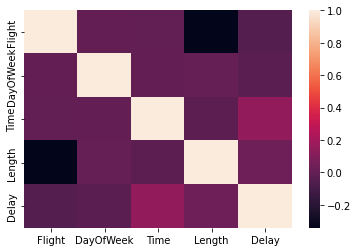

In [12]:
sns.heatmap(airline_df.corr())
plt.show()

#### Data preprocessing

Only keep airport name with top (threshold) number of flights

In [13]:
threshold = 25
from_top_30 = airline_df['AirportFrom'].value_counts().head(threshold).index
func = lambda x: x if (x in from_top_30) else 'other'
airline_df['AirportFrom'] = airline_df['AirportFrom'].apply(func)

to_top_30 = airline_df['AirportTo'].value_counts().head(threshold).index
func = lambda x: x if (x in to_top_30) else 'other'
airline_df['AirportTo'] = airline_df['AirportTo'].apply(func)

airline_df

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,269,SFO,IAH,3,15,205,1
1,US,1558,PHX,CLT,3,15,222,1
2,AA,2400,LAX,DFW,3,20,165,1
3,AA,2466,SFO,DFW,3,20,195,1
4,AS,108,other,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...
539378,CO,178,other,other,5,1439,326,0
539379,FL,398,SEA,ATL,5,1439,305,0
539380,FL,609,SFO,other,5,1439,255,0
539381,UA,78,other,SFO,5,1439,313,1


One hot encoding the catagorical features

In [14]:
one_hot = pd.get_dummies(airline_df[['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']])
airline_df = pd.concat([one_hot, airline_df[['Flight', 'Time', 'Length', 'Delay']]], axis=1)
airline_df

,DayOfWeek,Airline_9E,Airline_AA,Airline_AS,Airline_B6,Airline_CO,Airline_DL,Airline_EV,Airline_F9,Airline_FL,...,AirportTo_PHL,AirportTo_PHX,AirportTo_SEA,AirportTo_SFO,AirportTo_SLC,AirportTo_other,Flight,Time,Length,Delay
0,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,269,15,205,1
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1558,15,222,1
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2400,20,165,1
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2466,20,195,1
4,3,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,108,30,202,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539378,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,178,1439,326,0
539379,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,398,1439,305,0
539380,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,609,1439,255,0
539381,5,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,78,1439,313,1


#### Build Model

Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, classification_report

#clf = GaussianNB()
X = airline_df.iloc[:, :-1].to_numpy()
y = airline_df.iloc[:, -1:].to_numpy().squeeze()
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
for idx, (train_index, test_index) in enumerate(ss.split(X)):
    clf = GaussianNB()

    clf.fit(X[train_index], y[train_index])
    y_pred = clf.predict(X[test_index])
    f1 = f1_score(y[test_index], y_pred)
    print('Fold {}, F1 score: {:.3f}'.format(idx+1, f1))
    print(classification_report(y[test_index], y_pred))

Fold 1, F1 score: 0.574
              precision    recall  f1-score   support

           0       0.66      0.62      0.63     74976
           1       0.55      0.60      0.57     59870

    accuracy                           0.61    134846
   macro avg       0.60      0.61      0.60    134846
weighted avg       0.61      0.61      0.61    134846

Fold 2, F1 score: 0.570
              precision    recall  f1-score   support

           0       0.65      0.62      0.63     74894
           1       0.55      0.59      0.57     59952

    accuracy                           0.60    134846
   macro avg       0.60      0.60      0.60    134846
weighted avg       0.61      0.60      0.61    134846

Fold 3, F1 score: 0.574
              precision    recall  f1-score   support

           0       0.65      0.62      0.63     74571
           1       0.56      0.59      0.57     60275

    accuracy                           0.61    134846
   macro avg       0.60      0.60      0.60    134846
we

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

for idx, (train_index, test_index) in enumerate(ss.split(X)):
    clf = RandomForestClassifier(n_estimators=100, criterion='gini',
                                 max_depth=50)

    clf.fit(X[train_index], y[train_index])
    y_pred = clf.predict(X[test_index])
    f1 = f1_score(y[test_index], y_pred)
    print('Fold {}, F1 score: {:.3f}'.format(idx+1, f1))
    print(classification_report(y[test_index], y_pred))

Fold 1, F1 score: 0.566
              precision    recall  f1-score   support

           0       0.65      0.67      0.66     74976
           1       0.57      0.56      0.57     59870

    accuracy                           0.62    134846
   macro avg       0.61      0.61      0.61    134846
weighted avg       0.62      0.62      0.62    134846

Fold 2, F1 score: 0.563
              precision    recall  f1-score   support

           0       0.65      0.67      0.66     74894
           1       0.57      0.55      0.56     59952

    accuracy                           0.62    134846
   macro avg       0.61      0.61      0.61    134846
weighted avg       0.62      0.62      0.62    134846

Fold 3, F1 score: 0.564
              precision    recall  f1-score   support

           0       0.65      0.67      0.66     74571
           1       0.58      0.55      0.56     60275

    accuracy                           0.62    134846
   macro avg       0.61      0.61      0.61    134846
we

Deep learning (fully connected network)

Define Model

In [16]:
class Model(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):

        super(Model, self).__init__()

        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.dp = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):

        x = self.fc1(x)

        x = F.relu(x)

        x = self.fc2(x)

        return x

Dataloader

In [17]:
from torch.utils.data import Dataset

class Airline_Dataset(Dataset):
    def __init__(self, X, y):
        
        super(Airline_Dataset, self).__init__()
        
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)

        self.y = self.y.unsqueeze(1)

        #print(self.X.shape, self.y.shape)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda:0


In [28]:
from sklearn.preprocessing import StandardScaler

X = airline_df.iloc[:, :-1].to_numpy()
y = airline_df.iloc[:, -1:].to_numpy().squeeze()

scaler = StandardScaler()
X = scaler.fit_transform(X)

in_dim = X.shape[1]
hidden_dim = 512
learning_rate = 0.01
model = Model(in_dim, hidden_dim, 1) 
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = model.to(device)
model.train()

Model(
  (fc1): Linear(in_features=74, out_features=512, bias=True)
  (dp): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

Iterate through the dataloader

In [29]:
for idx, (train_index, test_index) in enumerate(ss.split(X)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break

train_loader = du.DataLoader(
        dataset=Airline_Dataset(X_train, y_train), 
        batch_size=100, shuffle=True)

for epoch in range(1, epochs + 1):
    sum_loss = 0.
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(X)

        loss = F.binary_cross_entropy_with_logits(output, y)

        sum_loss += loss.item()

        loss.backward()
        optimizer.step()

    sum_loss /= len(train_loader)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {sum_loss:.5f}')

Epoch: 10, Loss: 0.624
Epoch: 20, Loss: 0.623
Epoch: 30, Loss: 0.623
Epoch: 40, Loss: 0.623
Epoch: 50, Loss: 0.623
Epoch: 60, Loss: 0.623
Epoch: 70, Loss: 0.623
Epoch: 80, Loss: 0.623
Epoch: 90, Loss: 0.623
Epoch: 100, Loss: 0.623


In [30]:
model.eval()

test_loader = du.DataLoader(
        dataset=Airline_Dataset(X_test, y_test), 
        batch_size=100, shuffle=True)

valid_loss = 0
correct = 0
with torch.no_grad():
    for batch_idx, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)

        output = model(X)

        loss = F.binary_cross_entropy_with_logits(output, y)

        valid_loss += loss.item()

        pred = torch.sigmoid(output)
        pred[pred < float(0.5)] = 0
        pred[pred != 0] = 1
        correct += torch.sum((pred == y))

print('Accuracy: {:.4f}'.format(correct/len(X_test)))

Accuracy: 0.6517
